In [ ]:
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

import umap

from lib.phenotype.constants import DEFAULT_METADATA_COLS
from lib.aggregate.align import prepare_alignment_data, centerscale_on_controls
from lib.aggregate.cell_data_utils import load_metadata_cols, split_cell_data

In [2]:
filtered_data_dir = Path(
    "/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets"
)
filtered_data_paths = list(
    filtered_data_dir.glob("*_CeCl-all_ChCo-DAPI_CENPA__filtered.parquet")
)

len(filtered_data_paths)

18

In [4]:
data = ds.dataset(filtered_data_paths, format="parquet")
data = data.to_table(use_threads=True, memory_pool=None).to_pandas()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10784463 entries, 0 to 10784462
Columns: 898 entries, plate to cytoplasm_angle_between_neighbors
dtypes: Int64(50), bool(1), float32(1), float64(794), int64(48), object(1), string(3)
memory usage: 72.5+ GB


In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score


def get_perturbation_score(
    cell_data, gene, feature_cols, n_differential_features=200, auroc_cutoff=0.6
):
    """Per-cell perturbation scores via 5-fold out-of-fold logistic regression with top-k feature selection.

    AUROC guide:
      - < 0.6  → basically noise; don’t filter (return NaN scores and keep all cells)
      - 0.6–0.75 → weak/moderate separation; filter cautiously
      - > 0.75 → decent separation; filtering makes sense
      - > 0.85–0.9 → strong separation; filtering always safe and effective
    """
    y = (cell_data["gene_symbol_0"] == gene).astype(int).to_numpy()
    X_all = cell_data[feature_cols].to_numpy()

    # select top-k differential features (ANOVA F-test)
    k = min(n_differential_features, X_all.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k).fit(X_all, y)
    X = selector.transform(X_all)

    clf = LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear")
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    scores = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")[:, 1]

    auc = roc_auc_score(y, scores)
    if auc < auroc_cutoff:
        print(
            f"Warning: Perturbation AUROC for {gene} is {auc:.3f} (< {auroc_cutoff}), indicating"
            " no meaningful separation between perturbed and control cells."
        )

    # no meaningful separation → return NaNs so downstream keeps all cells
    return pd.Series(scores, index=cell_data.index), auc

In [83]:
# GENE = "RPS8"  # high perturbation score example
# GENE = "SKA3"  # low n, high perturbation score example
GENE = "PTP4A2"  # low perturbation score example

Gene: PTP4A2
Number of gene cells: 3559
Number of gene cells: 3559


/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [254 543 826] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Perturbation AUC for PTP4A2: 0.541


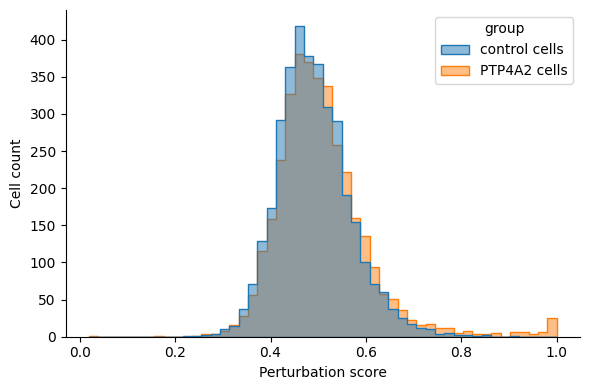

In [84]:
print(f"Gene: {GENE}")

gene_indices = data["gene_symbol_0"].str.contains(GENE, na=False).to_numpy().nonzero()[0]
nontargeting_indices = (
    data["gene_symbol_0"].str.contains("nontargeting", na=False).to_numpy().nonzero()[0]
)
nontargeting_indices = np.random.choice(
    nontargeting_indices, size=len(gene_indices), replace=False
)
combined_indices = np.union1d(gene_indices, nontargeting_indices)

subset_df = data.iloc[combined_indices].reset_index(drop=True)
print(f"Number of gene cells: {len(gene_indices)}")

metadata_cols = DEFAULT_METADATA_COLS + ["class", "confidence"]
feature_cols = subset_df.columns.difference(metadata_cols, sort=False)

metadata, features = split_cell_data(subset_df, metadata_cols)
metadata, features = prepare_alignment_data(
    metadata,
    features,
    ["plate", "well"],
    "gene_symbol_0",
    "nontargeting",
    "sgRNA_0",
)
features = features.astype(np.float32)

features = centerscale_on_controls(
    features,
    metadata,
    "gene_symbol_0",
    "nontargeting",
    "batch_values",
)
features = pd.DataFrame(features, columns=feature_cols)

subset_df_scaled = pd.concat([metadata, features], axis=1)

perturbation_scores, auc = get_perturbation_score(
    subset_df_scaled, GENE, feature_cols, 100
)
print(f"Perturbation AUC for {GENE}: {auc:.3f}")
subset_df_scaled["perturbation_score"] = perturbation_scores

plot_df = pd.concat(
    [
        subset_df_scaled[subset_df_scaled["gene_symbol_0"] != GENE].assign(
            group="control cells"
        ),
        subset_df_scaled[subset_df_scaled["gene_symbol_0"] == GENE].assign(
            group=f"{GENE} cells"
        ),
    ]
)

plt.figure(figsize=(6, 4))
sns.histplot(
    data=plot_df,
    x="perturbation_score",
    hue="group",
    bins=50,
    element="step",
    fill=True,
    stat="count",
    common_norm=False,
    alpha=0.5,
)
plt.xlabel("Perturbation score")
plt.ylabel("Cell count")
sns.despine()
plt.tight_layout()
plt.show()

/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [254 543 826] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


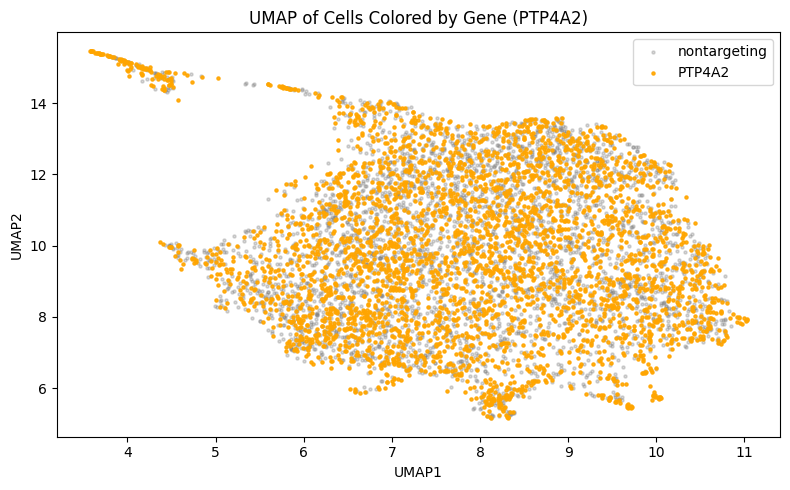

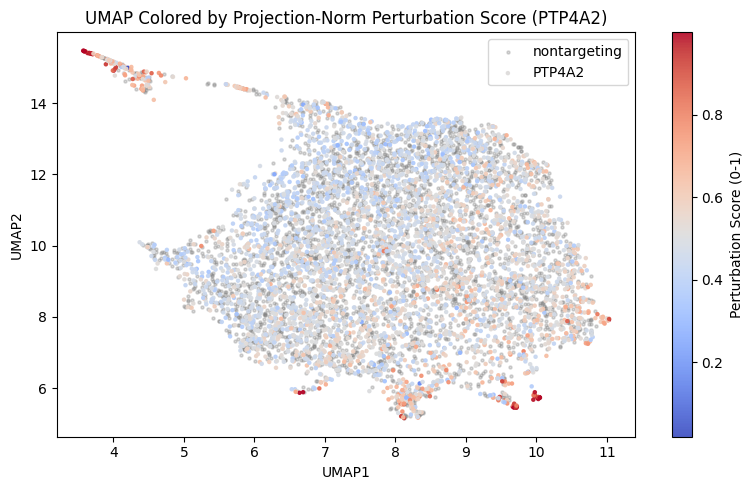

In [85]:
# Prepare data
X = subset_df_scaled[feature_cols]
control_X = subset_df_scaled[
    subset_df_scaled["gene_symbol_0"].str.startswith("nontargeting")
][feature_cols]
is_gene = subset_df_scaled["gene_symbol_0"] == GENE

# Feature selection
y = is_gene.astype(int)
k = 200
selector = SelectKBest(score_func=f_classif, k=k).fit(X.values, y.values)
X_selected = selector.transform(X.values)
control_X_selected = selector.transform(control_X.values)

# UMAP
umap_model = umap.UMAP(random_state=0, n_jobs=-1)
embedding = umap_model.fit_transform(X_selected)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    color="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.scatter(
    embedding[is_gene, 0],
    embedding[is_gene, 1],
    color="orange",
    s=5,
    alpha=0.9,
    label=GENE,
)
plt.legend()
plt.title(f"UMAP of Cells Colored by Gene ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    c="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.scatter(
    embedding[is_gene, 0],
    embedding[is_gene, 1],
    c=subset_df_scaled[is_gene]["perturbation_score"],
    cmap="coolwarm",
    s=5,
    alpha=0.9,
    label=GENE,
)
plt.legend()
plt.title(f"UMAP Colored by Projection-Norm Perturbation Score ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.colorbar(label="Perturbation Score (0-1)")
plt.tight_layout()
plt.show()

In [86]:
CUTOFF_METHOD = "probability_cutoff"
PROBABILITY_CUTOFF = 0.8

Number of PTP4A2 cells above probability cutoff 0.8: 69


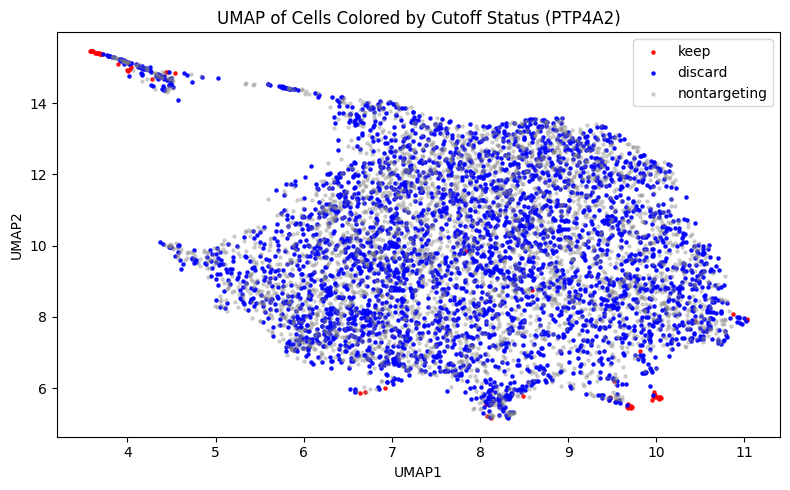

In [87]:
filtered_cells = subset_df_scaled[
    (subset_df_scaled["gene_symbol_0"] == GENE)
    & (subset_df_scaled["perturbation_score"] >= PROBABILITY_CUTOFF)
]
print(
    f"Number of {GENE} cells above probability cutoff {PROBABILITY_CUTOFF}: {len(filtered_cells)}"
)

# UMAP with cutoff coloring
keep_indices = filtered_cells.index
discard_indices = subset_df_scaled[(subset_df_scaled["gene_symbol_0"] == GENE) & (~subset_df_scaled.index.isin(keep_indices))].index

plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[subset_df_scaled.index.isin(keep_indices), 0],
    embedding[subset_df_scaled.index.isin(keep_indices), 1],
    color="red",
    s=5,
    alpha=0.9,
    label="keep",
)
plt.scatter(
    embedding[subset_df_scaled.index.isin(discard_indices), 0],
    embedding[subset_df_scaled.index.isin(discard_indices), 1],
    color="blue",
    s=5,
    alpha=0.9,
    label="discard",
)
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    color="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.legend()
plt.title(f"UMAP of Cells Colored by Cutoff Status ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

In [88]:
CUTOFF_METHOD = "top_n_percent"
TOP_N_PERCENT = 0.2

Number of PTP4A2 cells in top 20.0%: 711


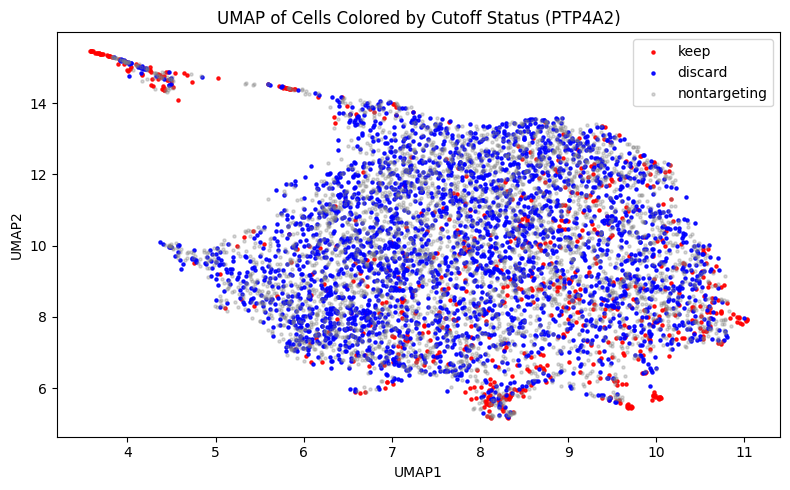

In [89]:
n_top = int(len(gene_indices) * TOP_N_PERCENT)
top_indices = subset_df_scaled[subset_df_scaled["gene_symbol_0"] == GENE][
    "perturbation_score"
].nlargest(n_top).index
filtered_cells = subset_df_scaled.loc[top_indices]
print(
    f"Number of {GENE} cells in top {TOP_N_PERCENT*100}%: {len(filtered_cells)}"
)

# UMAP with cutoff coloring
keep_indices = filtered_cells.index
discard_indices = subset_df_scaled[(subset_df_scaled["gene_symbol_0"] == GENE) & (~subset_df_scaled.index.isin(keep_indices))].index

plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[subset_df_scaled.index.isin(keep_indices), 0],
    embedding[subset_df_scaled.index.isin(keep_indices), 1],
    color="red",
    s=5,
    alpha=0.9,
    label="keep",
)
plt.scatter(
    embedding[subset_df_scaled.index.isin(discard_indices), 0],
    embedding[subset_df_scaled.index.isin(discard_indices), 1],
    color="blue",
    s=5,
    alpha=0.9,
    label="discard",
)
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    color="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.legend()
plt.title(f"UMAP of Cells Colored by Cutoff Status ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()